## Подготовка окружения

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve, accuracy_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


# Код для загрузки данных, очистки и подготовки

Выгружаем данные

In [8]:
data = pd.read_csv('/home/bertieta/projects/Web_service_06_ITS.ID_1549199-Team_TL_zizeklan.95974017_5f93_44fb-1/src/data/healthcare-dataset-stroke-data.csv', sep=',')

## Разведочный анализ данных (EDA)

In [9]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Видим пропуски в столбце "bmi"

In [11]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Видим что минимальный возраст 0.08, что немного странно

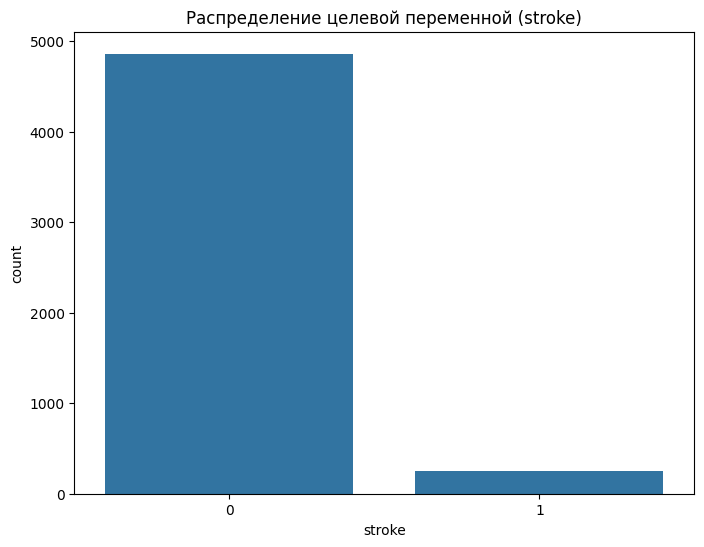

In [12]:
# Распределение целевой переменной
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=data)
plt.title('Распределение целевой переменной (stroke)')
plt.show()

Видим что больных инсультом гораздо меньше чем здоровых пациентов

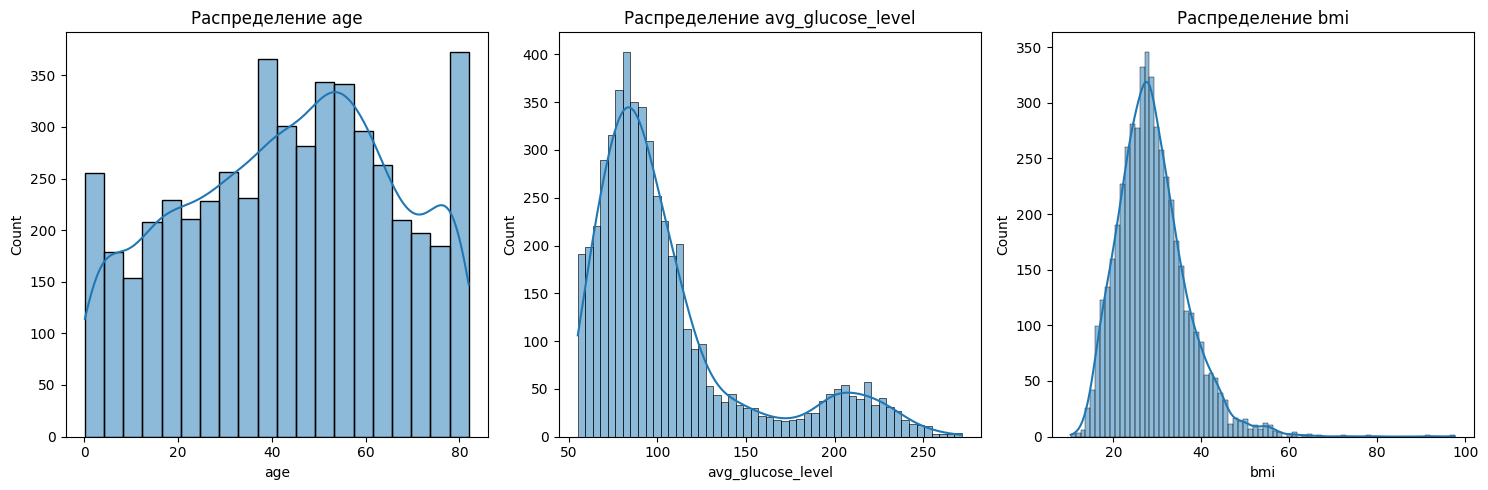

In [13]:
# Распределение числовых признаков
num_cols = ['age', 'avg_glucose_level', 'bmi']
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

Матрица корреляций

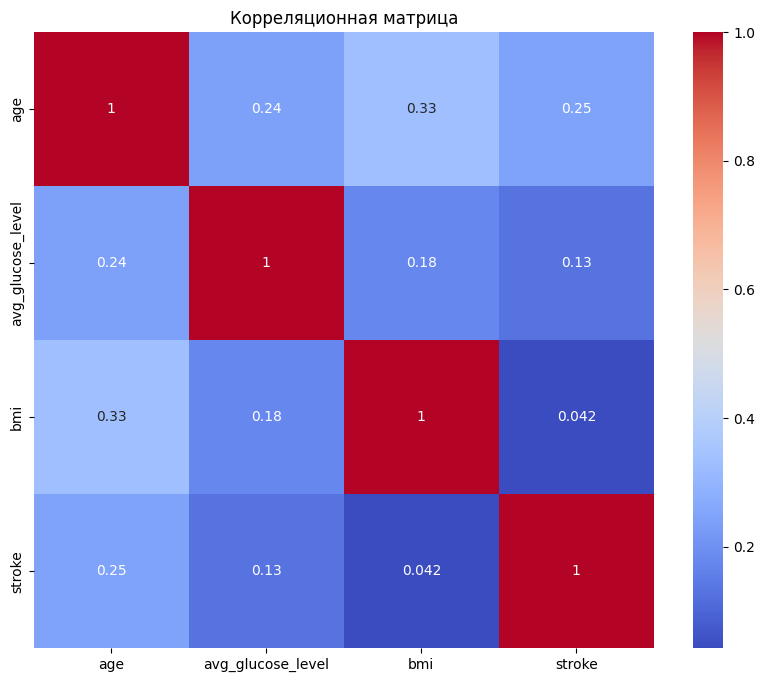

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_cols + ['stroke']].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Видим что индекс массы тела(BMI) почти не влияет на целевую переменную(stroke)

Позже удалим его

In [15]:
# Анализ категориальных признаков
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                'work_type', 'Residence_type', 'smoking_status']

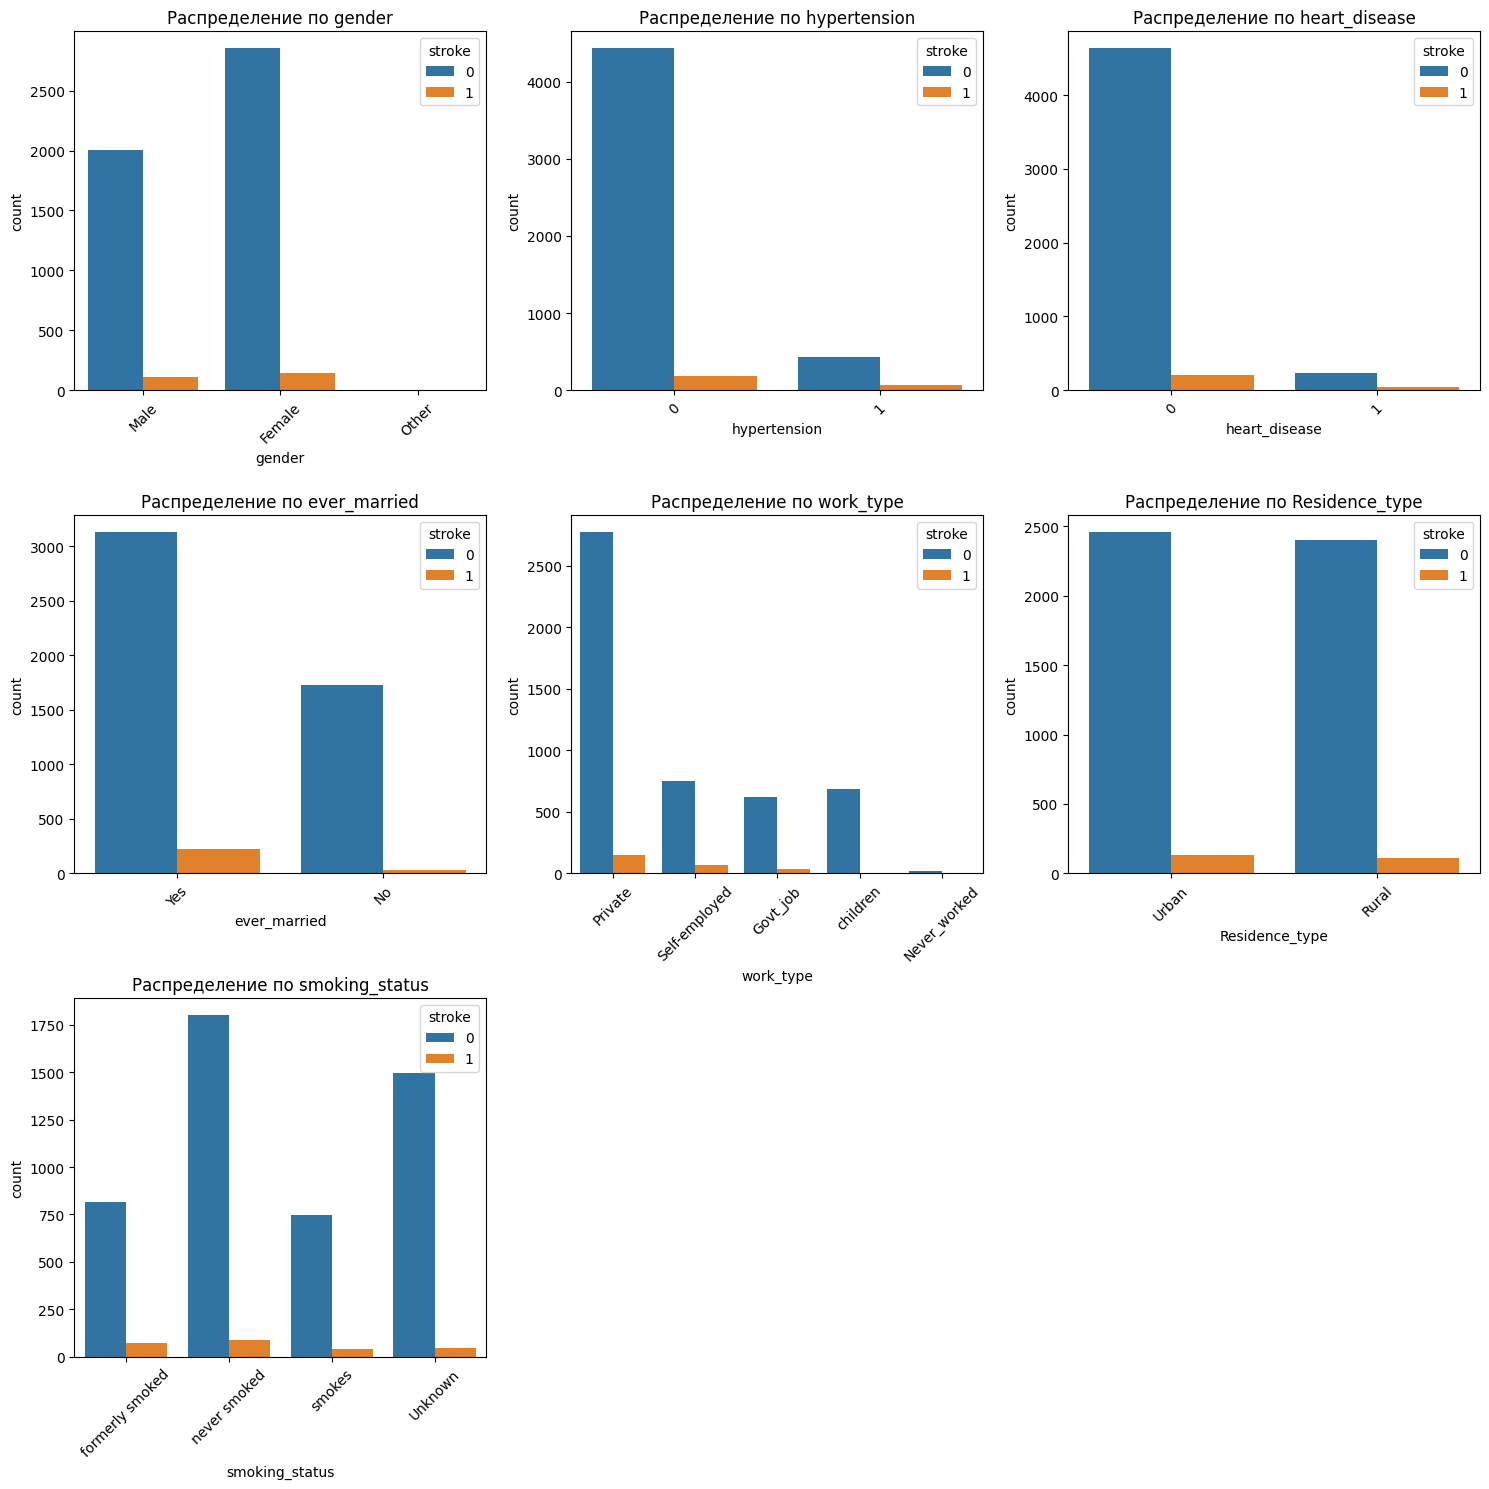

In [16]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, hue='stroke', data=data)
    plt.title(f'Распределение по {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Предобработка данных

In [17]:
#Находим количестов нулевых значений в столбцах
colls_null_proc =data.isnull().mean() * 100
print(colls_null_proc)

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


In [18]:
# Удаление столбца 'id' и 'bmi'
data.drop('id', axis=1, inplace=True)

## Разделение данных

In [19]:
# Разделение на признаки и целевую переменную
X = data.drop('stroke', axis=1)
y = data['stroke']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

## Подготовка данных

 Создание трансформеров для подготовки данных

In [20]:
# Определение трансформеров для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# SimpleImputer - инструмент для обработки пропущенных значений (NaN) в данных. 

Общий препроцессинг

In [21]:
# Определение категориальных и числовых признаков
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                       'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Код для обучения, сохранения и загрузки модели

## Функция для оценки моделей

In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Feature Importance (универсальный способ)
    try:
        # Для моделей с feature_importances_
        if hasattr(model.steps[-1][1], 'feature_importances_'):
            # Получаем имена фичей после препроцессинга
            num_feature_names = numerical_features
            cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat']\
                .named_steps['onehot'].get_feature_names_out(categorical_features)
            feature_names = np.concatenate([num_feature_names, cat_feature_names])
            
            importances = model.steps[-1][1].feature_importances_
            indices = np.argsort(importances)[::-1]
            
            plt.figure(figsize=(12, 8))
            plt.title("Feature Importances")
            plt.bar(range(len(importances)), importances[indices], align="center")
            plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
            plt.xlim([-1, len(importances)])
            plt.tight_layout()
            plt.show()
        
        # Для моделей с coef_
        elif hasattr(model.steps[-1][1], 'coef_'):
            num_feature_names = numerical_features
            cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat']\
                .named_steps['onehot'].get_feature_names_out(categorical_features)
            feature_names = np.concatenate([num_feature_names, cat_feature_names])
            
            coef = model.steps[-1][1].coef_[0]
            indices = np.argsort(np.abs(coef))[::-1]
            
            plt.figure(figsize=(12, 8))
            plt.title("Feature Coefficients (absolute values)")
            plt.bar(range(len(coef)), np.abs(coef[indices]), align="center")
            plt.xticks(range(len(coef)), feature_names[indices], rotation=90)
            plt.xlim([-1, len(coef)])
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Could not plot feature importance: {e}")

Создаём пайплайны

In [23]:
# Создаем пайплайны для моделей
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', 
                               random_state=42, 
                               max_iter=1000))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced_subsample',
                                   random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1),
                          random_state=42,
                          eval_metric='logloss'))
])

# Словарь моделей для оценки
models = {
    'Logistic Regression': logreg_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline
}


## Обучение моделей 


=== Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022

Accuracy: 0.7466
ROC-AUC: 0.8437
Precision: 0.1384
Recall: 0.8000
F1 Score: 0.2360


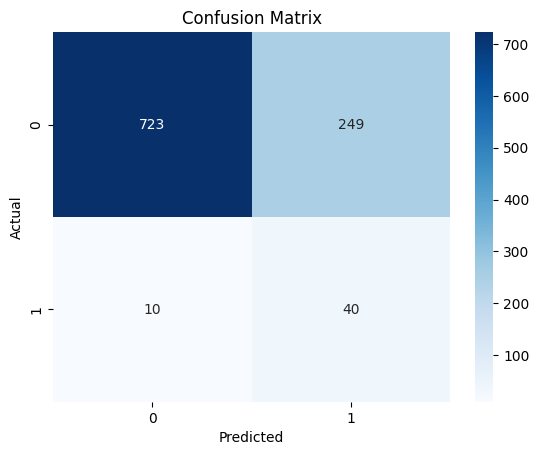

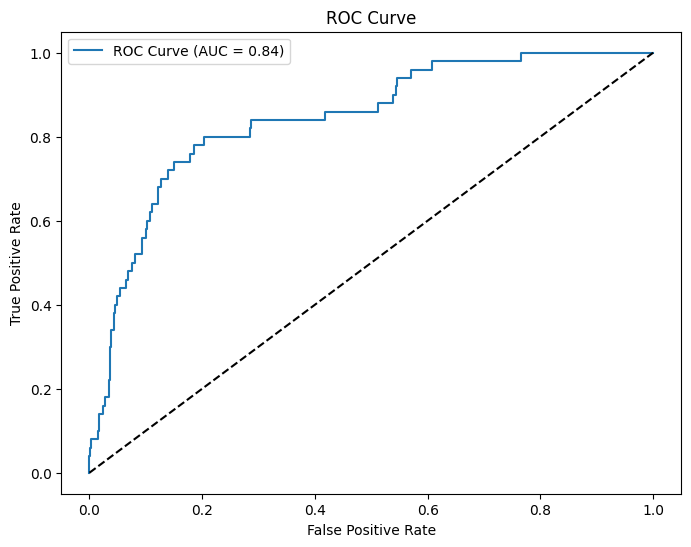

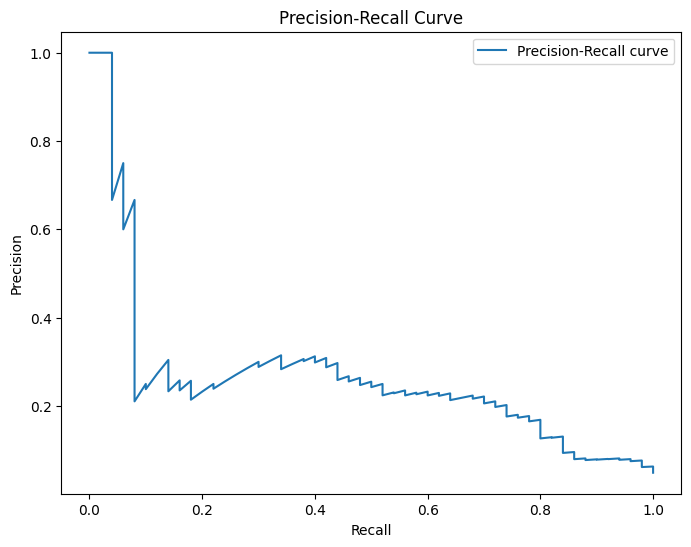

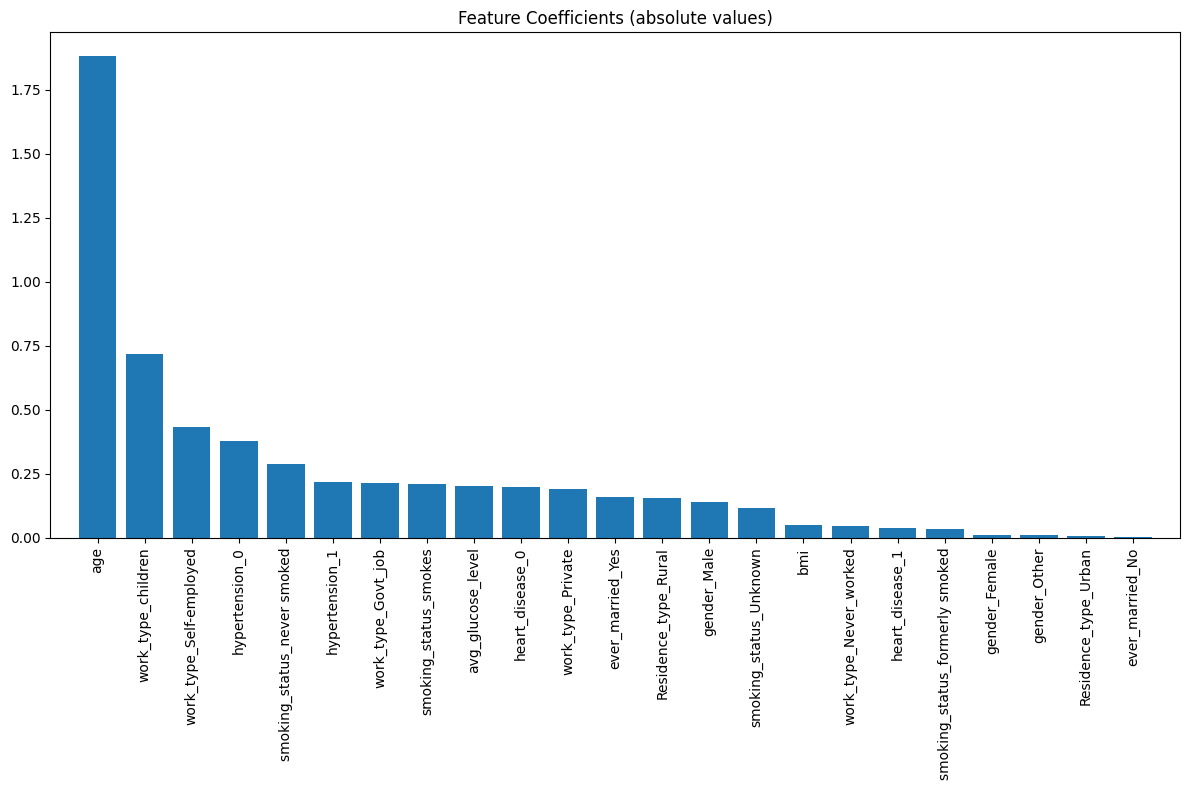


=== Random Forest ===

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Accuracy: 0.9472
ROC-AUC: 0.7791
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


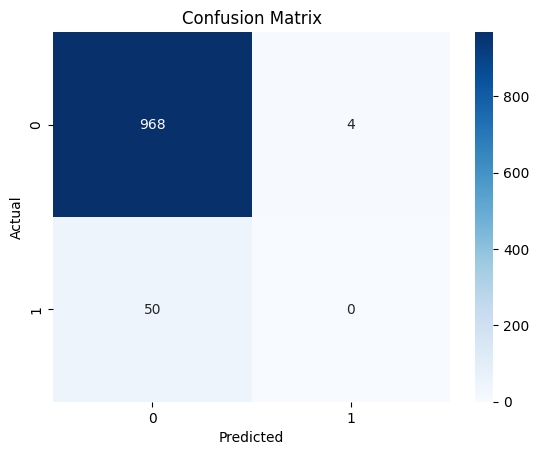

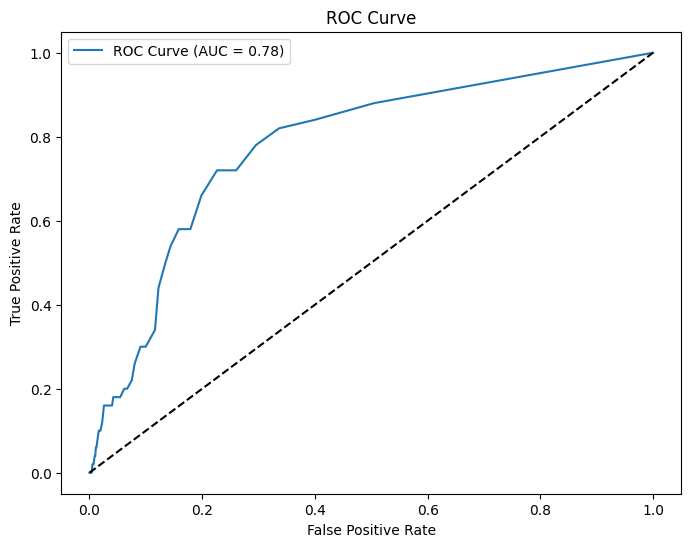

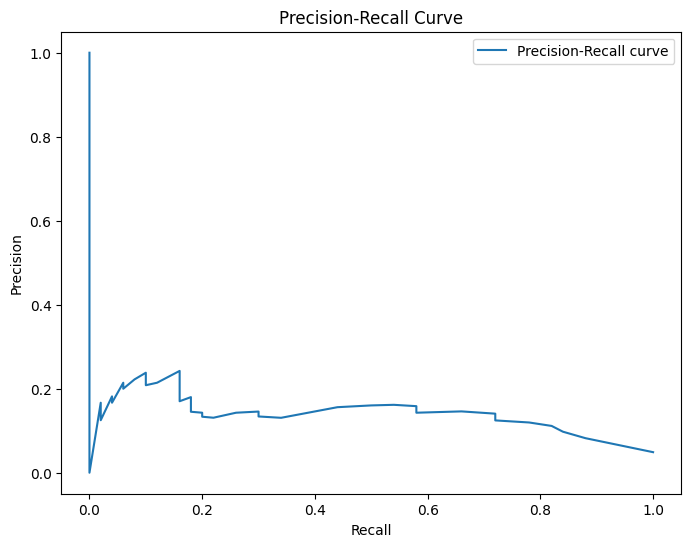

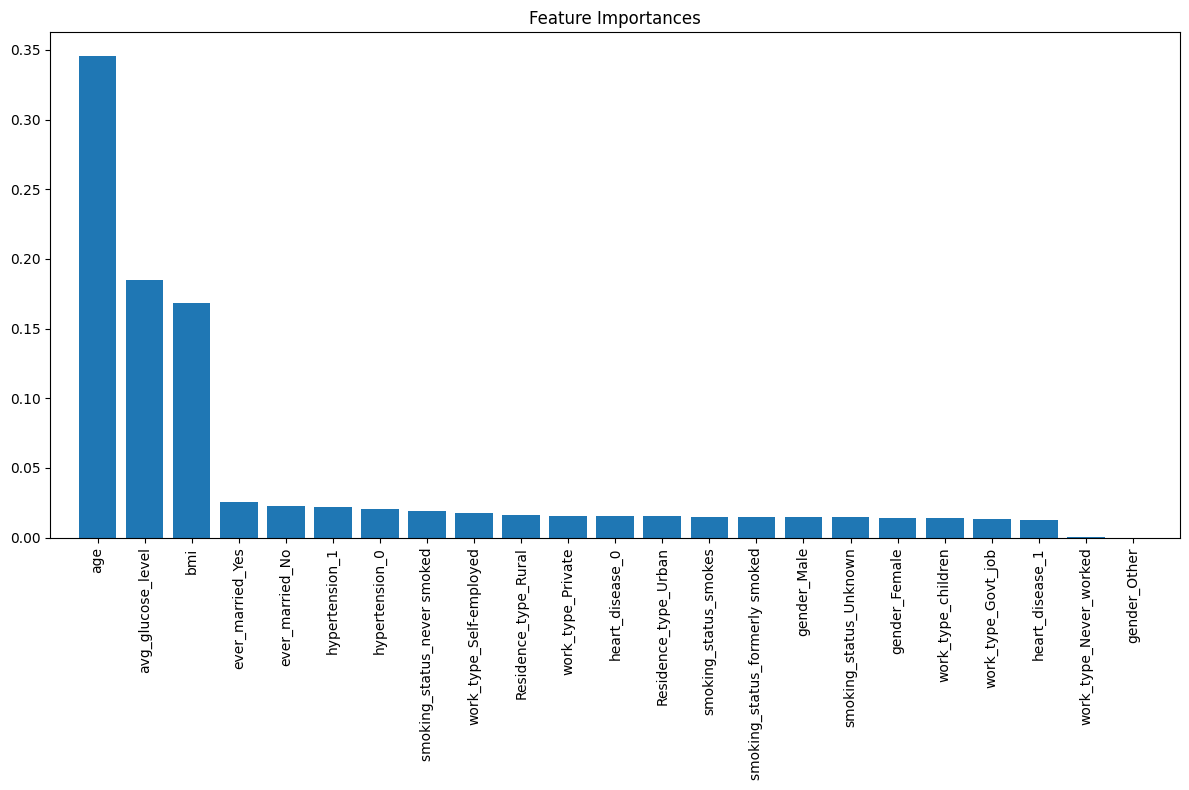


=== XGBoost ===

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       972
           1       0.27      0.18      0.22        50

    accuracy                           0.94      1022
   macro avg       0.62      0.58      0.59      1022
weighted avg       0.92      0.94      0.93      1022

Accuracy: 0.9364
ROC-AUC: 0.7807
Precision: 0.2727
Recall: 0.1800
F1 Score: 0.2169


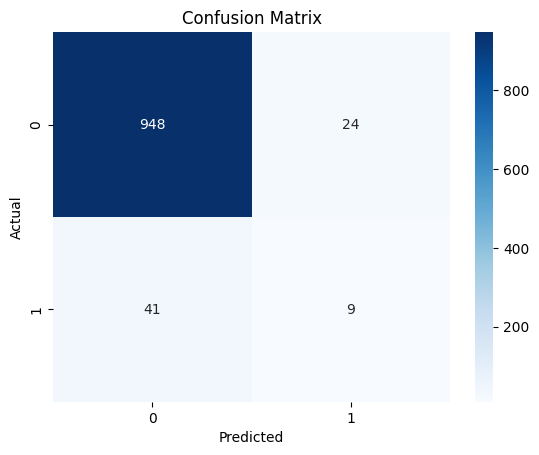

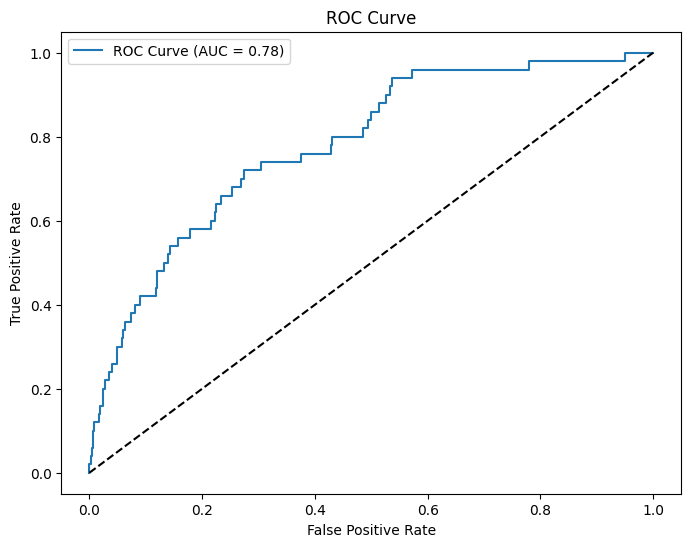

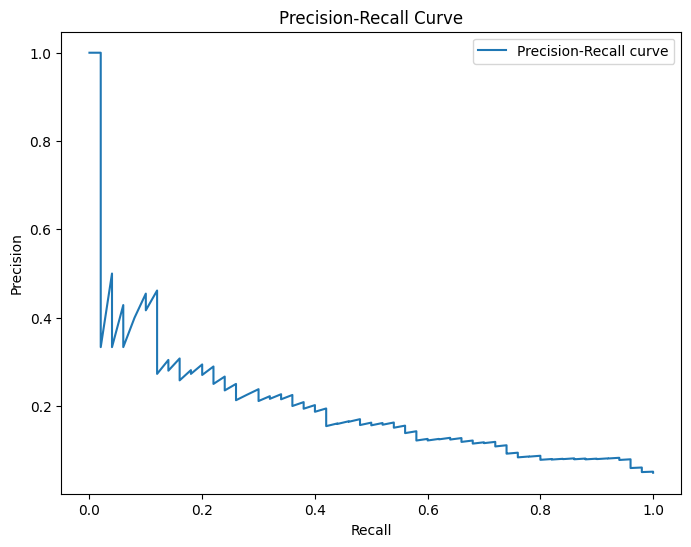

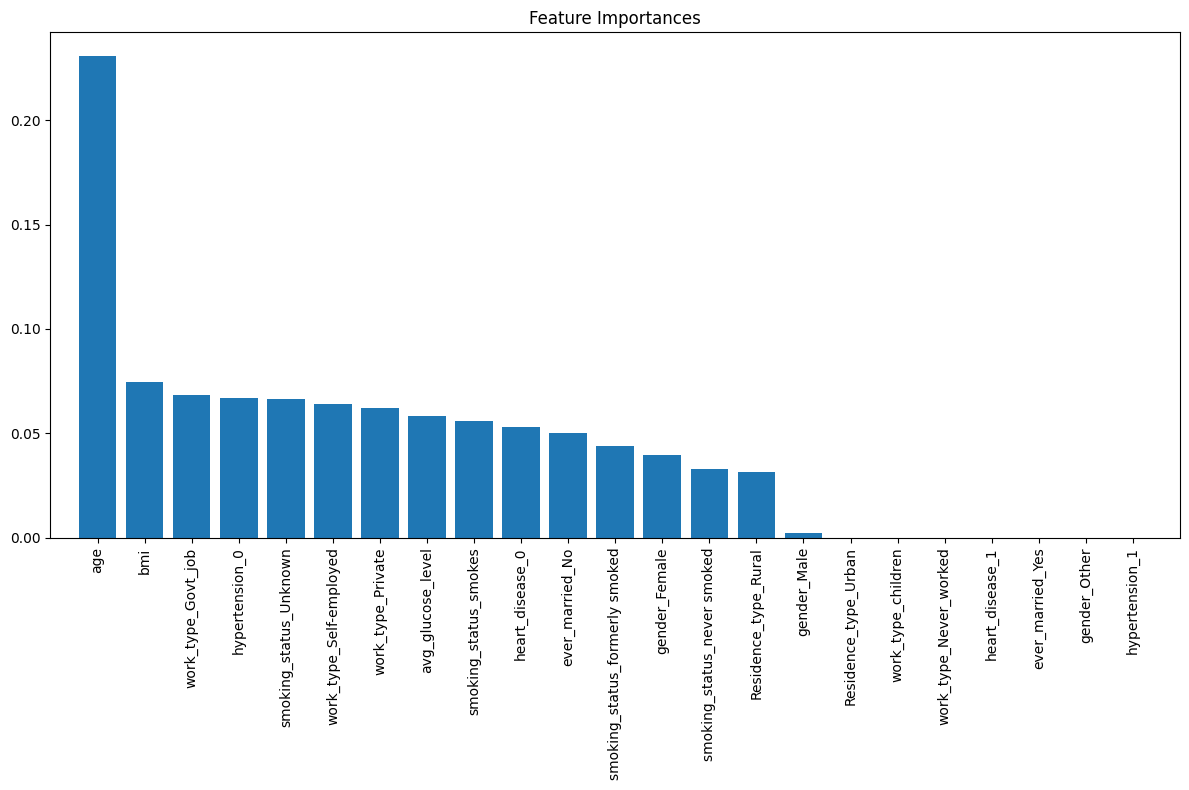

In [24]:
# Обучаем и оцениваем модели
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"=== {name} ===")
    print(f"{'='*40}")
    
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test)

Видим что XGBoost справился лучше всех: У него самый высокий precision и recall для класса 1(наличие инсульта)

In [25]:
# Подбор гиперпараметров для XGBoost
print("\nНачинаем подбор гиперпараметров для XGBoost...")
param_grid = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)



Начинаем подбор гиперпараметров для XGBoost...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_freq...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [26]:
# Выводим лучшие параметры
print("\nЛучшие параметры XGBoost:")
print(xgb_grid.best_params_)
print(f"Лучший ROC-AUC: {xgb_grid.best_score_:.4f}")



Лучшие параметры XGBoost:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.8}
Лучший ROC-AUC: 0.8378



Оценка лучшей модели XGBoost на тестовых данных:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.82      0.22        50

    accuracy                           0.71      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.71      0.79      1022

Accuracy: 0.7104
ROC-AUC: 0.8526
Precision: 0.1250
Recall: 0.8200
F1 Score: 0.2169


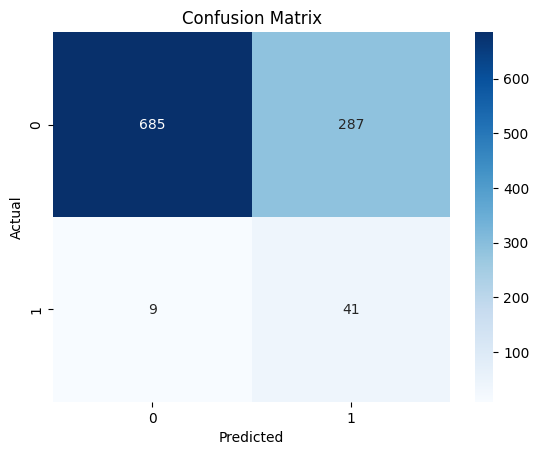

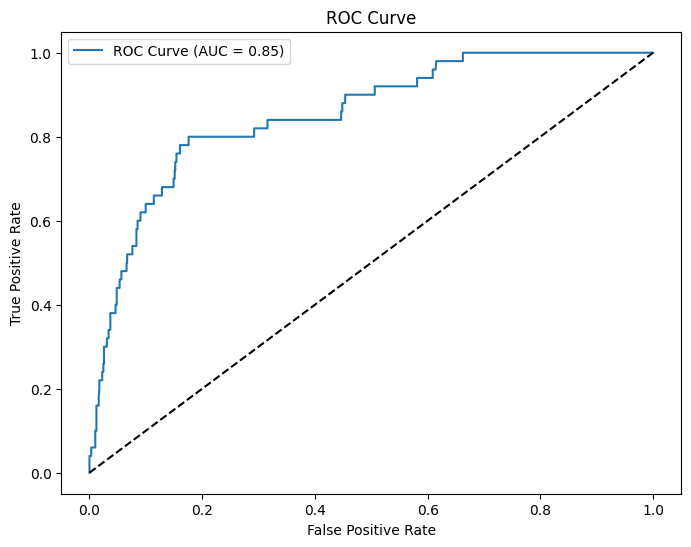

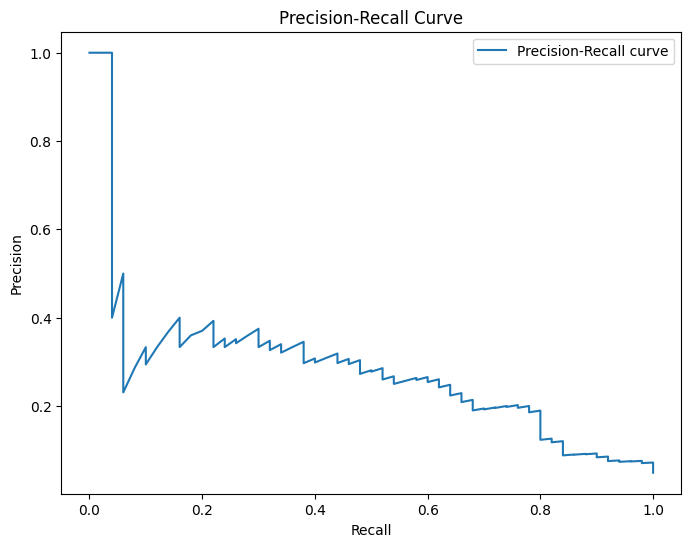

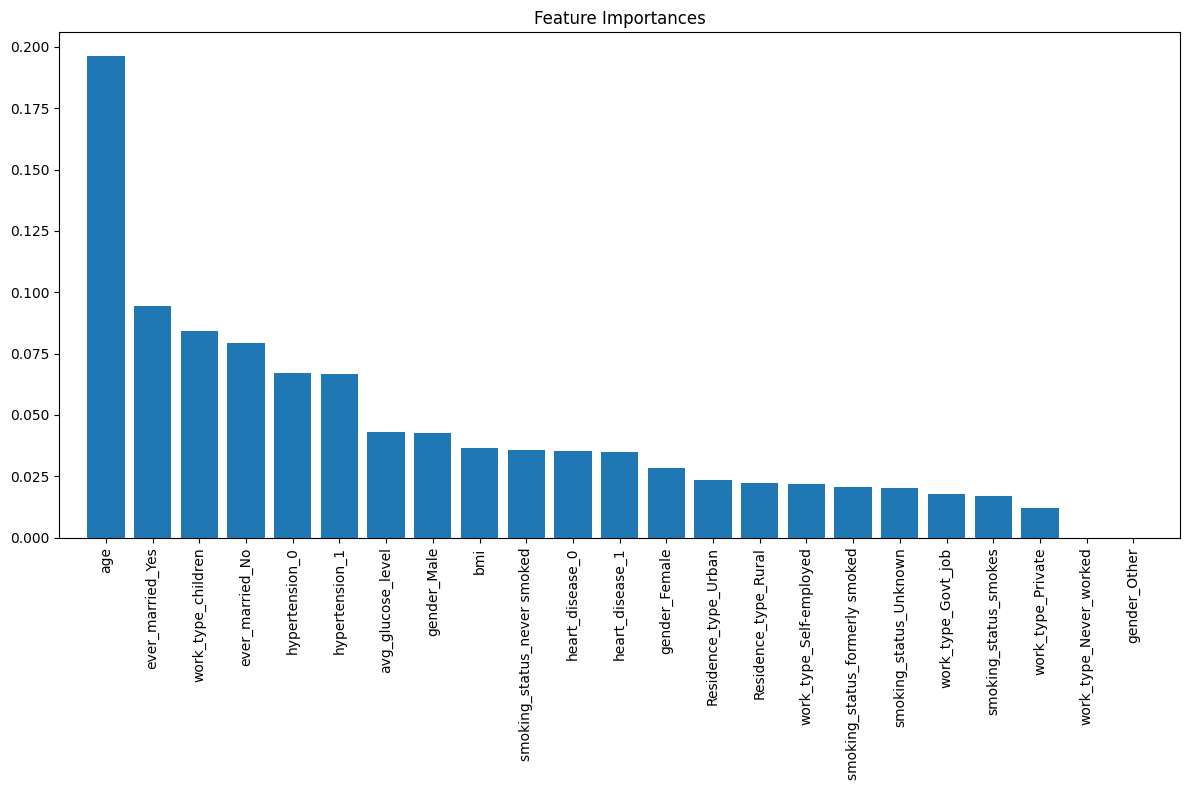

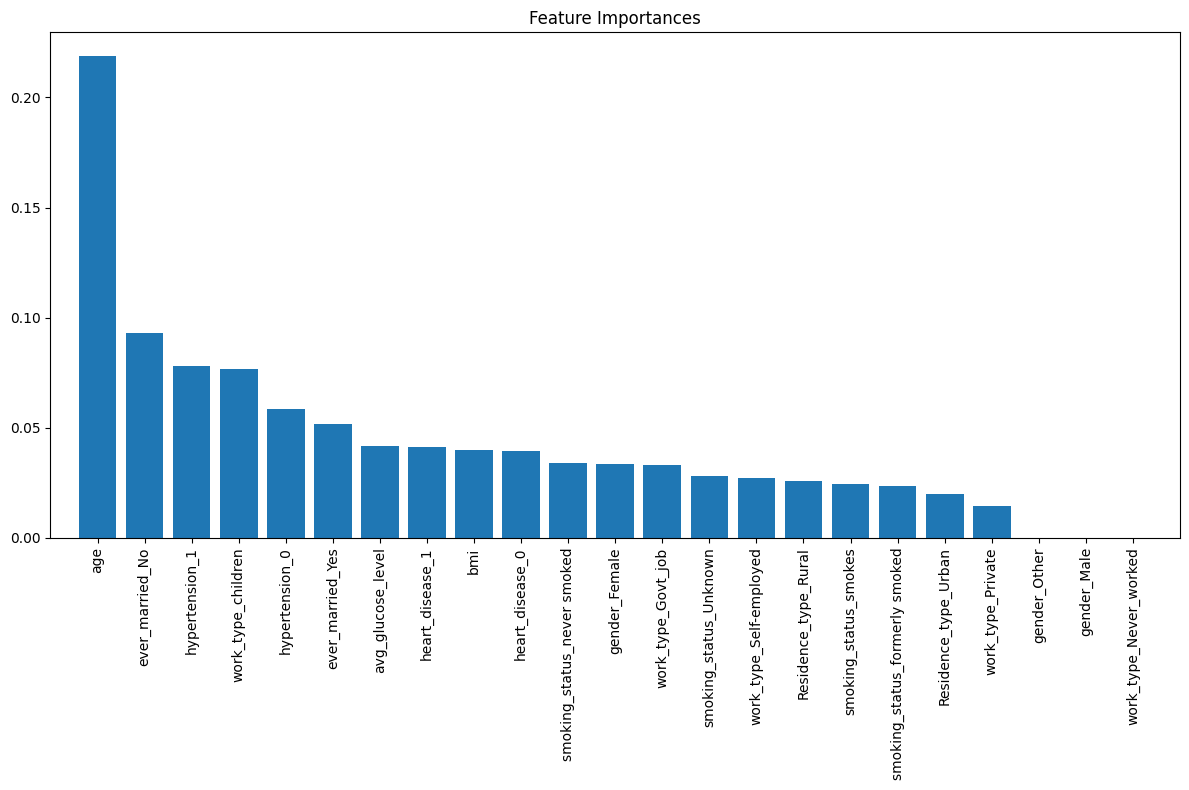

In [27]:
# Оцениваем лучшую модель
print("\nОценка лучшей модели XGBoost на тестовых данных:")
best_xgb = xgb_grid.best_estimator_
evaluate_model(best_xgb, X_test, y_test)

In [28]:
# Сохраняем лучшую модель
joblib.dump(best_xgb, '/home/bertieta/projects/Web_service_06_ITS.ID_1549199-Team_TL_zizeklan.95974017_5f93_44fb-1/src/data/best_stroke_model.pkl')
print("\nЛучшая модель сохранена как 'best_stroke_model.pkl'")


Лучшая модель сохранена как 'best_stroke_model.pkl'


# Функция для предсказания степени риска

In [62]:
def predict_stroke_risk(model, input_data, categorical_features, numerical_features):
    """Прогнозирование риска инсульта и классификация уровня риска"""
    # Преобразование входных данных в DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Предсказание вероятности
    probability = model.predict_proba(input_df)[0, 1]
    
    # Классификация уровня риска
    if probability < 0.1:
        risk_level = "Крайне низкий"
    elif probability < 0.3:
        risk_level = "Низкий"
    elif probability < 0.5:
        risk_level = "Значительный"
    elif probability < 0.7:
        risk_level = "Высокий"
    else:
        risk_level = "Крайне высокий"
    
    return probability, risk_level


In [66]:
# Пример использования модели для прогнозирования
example_input = {
        'gender': 'Male',
        'age': 15,
        'hypertension': 1,
        'heart_disease': 1,
        'ever_married': 1,
        'work_type': 'Private',
        'Residence_type': 1,
        'avg_glucose_level': 228.69,
        'bmi': 36.6,
        'smoking_status': 'formerly smoked'
    }
    
probability, risk_level = predict_stroke_risk(best_xgb, example_input, 
                                                 categorical_features, numerical_features)
print(f"\nПример прогнозирования:")
print(f"Входные данные: {example_input}")
print(f"Вероятность инсульта: {probability:.4f}")
print(f"Уровень риска: {risk_level}")


Пример прогнозирования:
Входные данные: {'gender': 'Male', 'age': 15, 'hypertension': 1, 'heart_disease': 1, 'ever_married': 1, 'work_type': 'Private', 'Residence_type': 1, 'avg_glucose_level': 228.69, 'bmi': 36.6, 'smoking_status': 'formerly smoked'}
Вероятность инсульта: 0.1888
Уровень риска: Низкий
